In [1]:
import numpy as np
import torch
from torch import nn
import LightPipes as lp
import matplotlib.pyplot as plt
import os, sys, h5py
main_dir = os.path.abspath('../')
sys.path.append(main_dir)

from utils.functions import *
from utils.models.modalevaluator import ModalEvaluator


device = 'cuda:3'

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


truncate_circle = True

Load the Modes and the derivatives

In [2]:
microlens = 20 #20x20
size = microlens

n_zernike_rows = 4
n_zernike = n_zernike_rows*(n_zernike_rows+1)//2

x = torch.linspace(-1,1,size)
y = torch.linspace(-1,1,size)

xx, yy = torch.meshgrid(x,y)

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Make a custom wavefront...

Text(0.5, 1.0, 'True Wavefront Derivative')

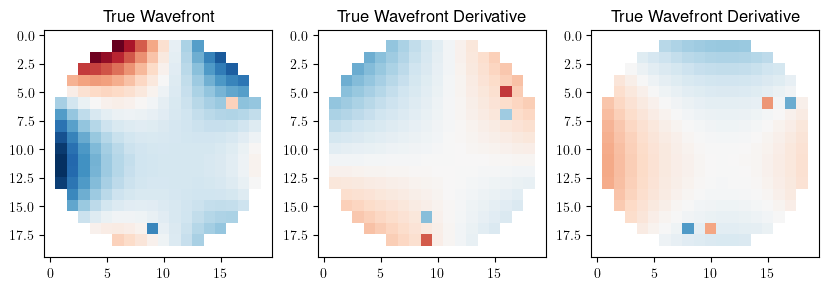

In [3]:
wavefront = torch.zeros(size,size)

decenter = [0.2,0.2] #lets say we're off center...
# decenter = [0,0] #lets say we're off center...

modes, mode_derivs = get_modes_and_derivs(decenter, xx, yy, n_zernike=n_zernike_rows, truncate_circle=truncate_circle, pixel_basis = True)

mode_coeffs = torch.zeros((len(modes),1,1))


mode_coeffs[n_zernike-4] = 1
# mode_coeffs[n_zernike] = 1

mode_coeffs[360] = 1 # we have some noise
mode_coeffs[147] = -1 # we have some noise

wavefront = torch.sum(mode_coeffs * modes,dim=0)
wavefront_deriv = torch.sum(mode_coeffs * mode_derivs,dim=1)


fig,ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(wavefront, cmap='RdBu'); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_deriv[0],vmax=1,vmin=-1, cmap='RdBu'); ax[1].set_title('True Wavefront Derivative')
ax[2].imshow(wavefront_deriv[1],vmax=1,vmin=-1, cmap='RdBu'); ax[2].set_title('True Wavefront Derivative')

## From here I show once we have gradients


In [4]:
sampled_gradient = wavefront_deriv.clone()
# sampled_gradient[:,10,10] = np.nan

# sampled_gradient+=torch.randn_like(sampled_gradient)*0.01 * torch.max(torch.nan_to_num(sampled_gradient))

num_inits = 25

evaller = ModalEvaluator(size=(size,size), initializations=num_inits, n_zernike_rows=n_zernike_rows, zern_transform=True, pixel_basis=True, device=device)

In [5]:
init_transX, init_transY = np.meshgrid(np.linspace(-.2, .2, 5), np.linspace(-.2, .2, 5))

init_rot, init_transX, init_transY = [0.]*num_inits, init_transX.flatten(), init_transY.flatten()

coeffs, history = evaller.fit(sampled_gradient, affine_initialization=[init_rot, init_transX, init_transY], epochs=5000, lr=3e-3, l1_reg=7e-4)

/home/s/Sunny.Howard/overdictionary/utils/models/modalevaluator.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavefront_derivs = torch.tensor(wavefront_derivs).permute(1,0).tile(self.initializations,1).float().to(self.device)


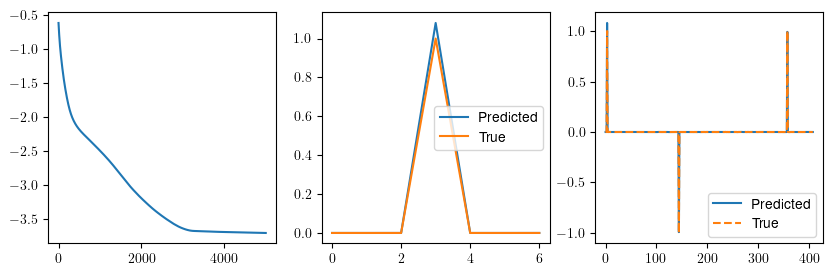

In [6]:
fig,ax = plt.subplots(1,3, figsize = (10,3))
ax[0].plot(np.log10(history['loss']))
ax[1].plot(coeffs['coefficients'][evaller.best_init,3:n_zernike].detach().cpu())
ax[1].plot(mode_coeffs[3:n_zernike,0,0])
ax[1].legend(['Predicted','True'])
ax[2].plot(coeffs['coefficients'][evaller.best_init,3:].detach().cpu())
ax[2].plot(mode_coeffs[3:,0,0],'--')
ax[2].legend(['Predicted','True'])

In [7]:
print(history['per_init_loss'])

[6.1088991e-07 6.3060315e-07 6.7401930e-07 6.0819934e-07 6.1536394e-07
 6.6004412e-07 6.0438032e-07 6.3790702e-07 6.2113554e-07 6.5459210e-07
 7.2330755e-07 6.2442558e-07 7.0325387e-07 8.3195164e-07 7.0795602e-07
 7.6205208e-07 6.2945844e-07 7.9082918e-07 8.1971518e-07 7.3902231e-07
 6.3263280e-07 7.7285205e-07 6.2462703e-07 6.2440023e-07 7.6862301e-07]


In [8]:
wavefront_pred, derivs_pred =  evaller.get_wavefront(coeffs, microlens_pitch=1)

/home/s/Sunny.Howard/overdictionary/utils/models/affinemodel.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transX_list = nn.Parameter(torch.tensor(theta[:,0,2].clone().detach()))
/home/s/Sunny.Howard/overdictionary/utils/models/affinemodel.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.transY_list = nn.Parameter(torch.tensor(theta[:,1,2].clone().detach()))
/home/s/Sunny.Howard/overdictionary/utils/models/affinemodel.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rot_list = nn.Parameter(torch.tensor(angle

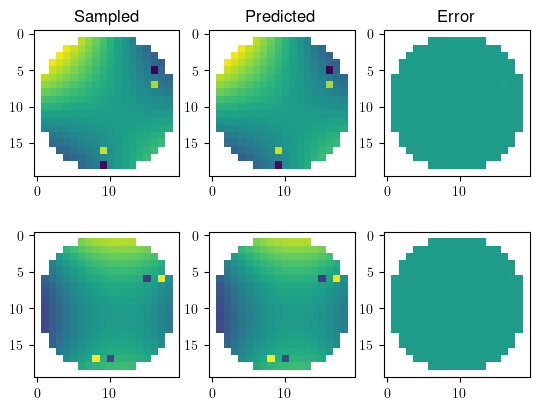

In [9]:
vmax = torch.nan_to_num(sampled_gradient).max()*.9
vmin = torch.nan_to_num(sampled_gradient).min()*.9

fig,ax = plt.subplots(2,3,dpi=100)
ax[0,0].imshow(sampled_gradient[0],vmax=vmax, vmin=vmin); ax[0,0].set_title('Sampled')
ax[0,1].imshow(derivs_pred[0],vmax=vmax, vmin=vmin); ax[0,1].set_title('Predicted')
ax[0,2].imshow(sampled_gradient[0]-derivs_pred[0],vmax=vmax, vmin=vmin); ax[0,2].set_title('Error')

ax[1,0].imshow(sampled_gradient[1],vmax=vmax, vmin=vmin)
ax[1,1].imshow(derivs_pred[1],vmax=vmax, vmin=vmin)
ax[1,2].imshow(sampled_gradient[1]-derivs_pred[1],vmax=vmax, vmin=vmin)

Text(0.5, 1.0, 'Error')

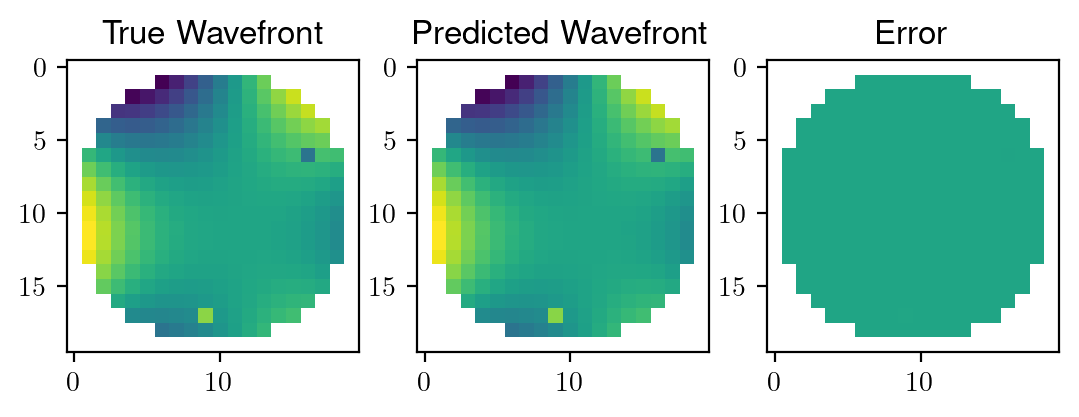

In [10]:
vmax = np.nan_to_num(wavefront).max()
vmin = np.nan_to_num(wavefront).min()

fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(wavefront,vmax=vmax,vmin=vmin); ax[0].set_title('True Wavefront')
ax[1].imshow(wavefront_pred,vmax=vmax,vmin=vmin); ax[1].set_title('Predicted Wavefront')
ax[2].imshow(wavefront-wavefront_pred,vmax=vmax,vmin=vmin); ax[2].set_title('Error')

#(wavefront_pred/wavefront).mean(), (wavefront_pred/wavefront).std()

## Lasso

In [11]:
fit_modes, fit_mode_derivs = get_modes_and_derivs([0.,0.], xx, yy, n_zernike=n_zernike_rows, truncate_circle=False, pixel_basis = True)
fit_mode_derivs[:,:,torch.isnan(sampled_gradient[0])] = torch.nan
fit_modes[:, torch.isnan(sampled_gradient[0])] = torch.nan

wavefront_grad_prediction_01, result_vector_01 = LassoFit(sampled_gradient, fit_mode_derivs, alpha=0.01)
wavefront_grad_prediction_008, result_vector_008 = LassoFit(sampled_gradient, fit_mode_derivs, alpha=0.008)
wavefront_grad_prediction_005, result_vector_005 = LassoFit(sampled_gradient, fit_mode_derivs, alpha=0.005)
wavefront_grad_prediction_001, result_vector_001 = LassoFit(sampled_gradient, fit_mode_derivs, alpha=0.001)

wavefront_prediction_01 = (fit_modes.permute(1,2,0) @ result_vector_01)
wavefront_prediction_008 = (fit_modes.permute(1,2,0) @ result_vector_008)
wavefront_prediction_005 = (fit_modes.permute(1,2,0) @ result_vector_005)
wavefront_prediction_001 = (fit_modes.permute(1,2,0) @ result_vector_001)

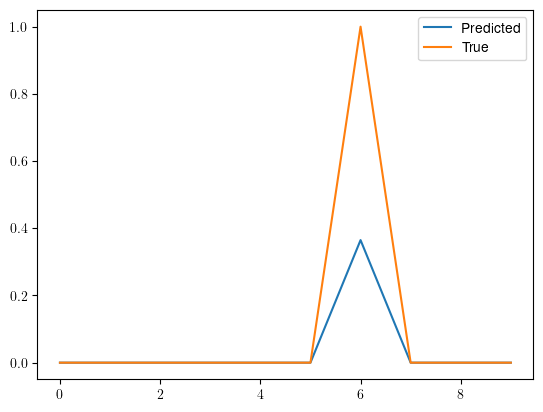

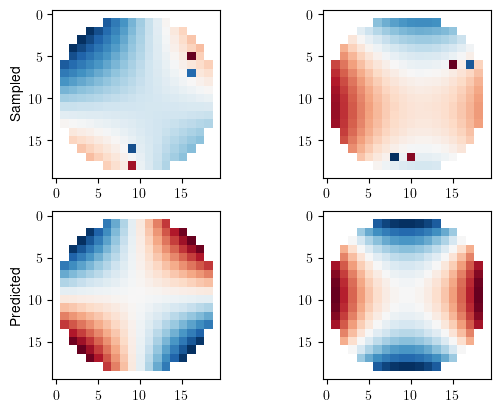

In [12]:
fig,ax = plt.subplots(1,1)
ax.plot(result_vector_01[:n_zernike])
ax.plot(mode_coeffs[:n_zernike,0,0])
ax.legend(['Predicted','True'])

fig,ax = plt.subplots(2,2,dpi=100)
ax[0,0].imshow(sampled_gradient[0], cmap='RdBu'); ax[0,0].set_ylabel('Sampled')
ax[0,1].imshow(sampled_gradient[1], cmap='RdBu')
ax[1,0].imshow(wavefront_grad_prediction_01[0], cmap='RdBu'); ax[1,0].set_ylabel('Predicted')
ax[1,1].imshow(wavefront_grad_prediction_01[1], cmap='RdBu')


In [13]:
from matplotlib import rc

# Set the font family to serif and specify Times New Roman
rc('font',**{'family':'serif','serif':['CMU Serif Roman']})
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# Enable LaTeX for text rendering
rc('text', usetex=True)

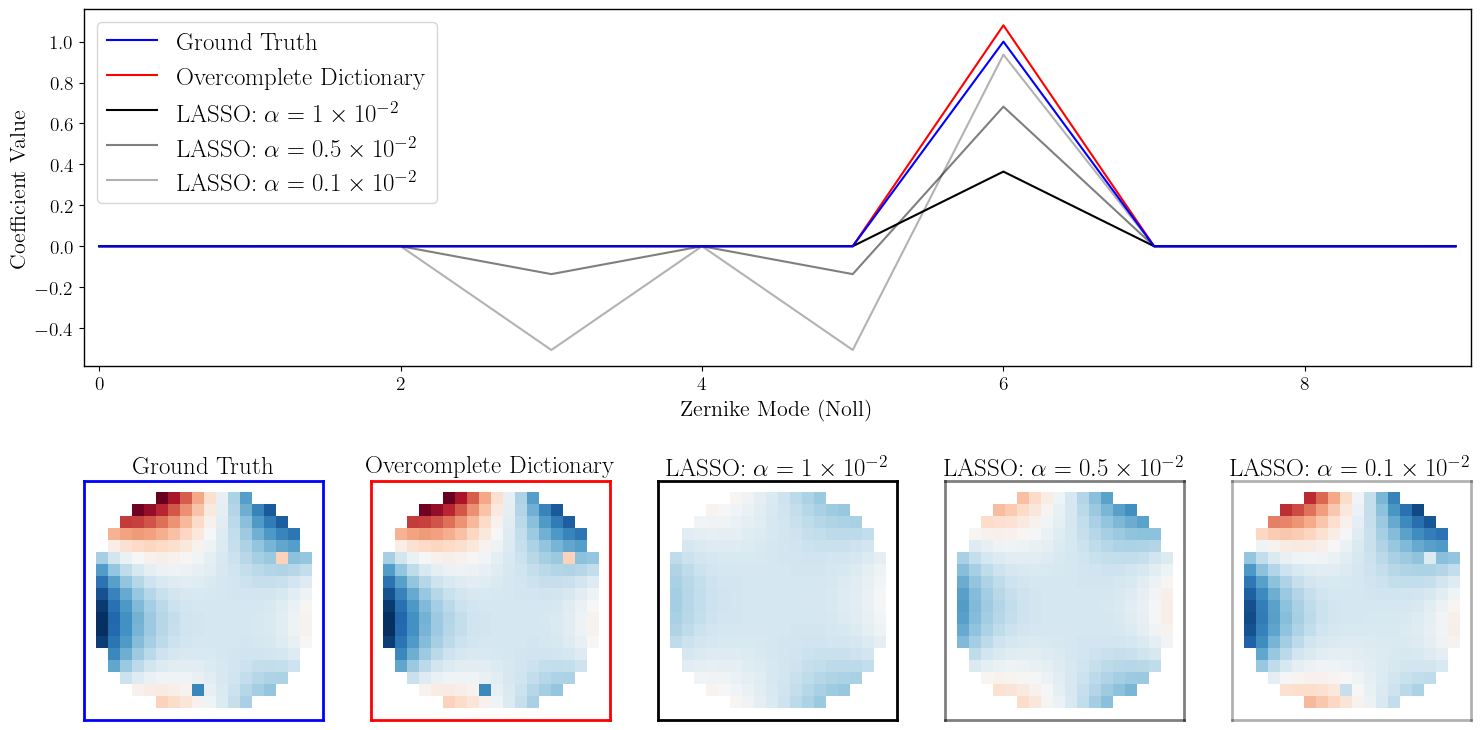

In [16]:
# Modify the layout to have the 6 subplots in a 1x6 layout in the second row

# Create a figure with 2 rows
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

colors = ['blue', 'red', 'k', 'k', 'k']
alpha = [1,1,1,.5,.3]


# First row: Line plot
ax1 = fig.add_subplot(gs[0])
ax1.plot(mode_coeffs[:n_zernike,0,0], 'b', zorder=10000, )
ax1.plot(coeffs['coefficients'][evaller.best_init,:n_zernike].detach().cpu(), 'r')
ax1.plot(result_vector_01[:n_zernike], 'k', alpha=1)
# ax1.plot(result_vector_0075[:n_zernike], 'k', alpha=.6)
ax1.plot(result_vector_005[:n_zernike], 'k', alpha = .5)
ax1.plot(result_vector_001[:n_zernike], 'k', alpha = .3)

labels = ['Ground Truth','Overcomplete Dictionary', r'LASSO: $\alpha = 1\times 10^{-2}$', r'LASSO: $\alpha = 0.5\times 10^{-2}$', r'LASSO: $\alpha = 0.1\times 10^{-2}$', ]

ax1.legend(labels, fontsize=18, loc='upper left')

ax1.set_ylabel('Coefficient Value', fontsize=16)
ax1.set_xlabel('Zernike Mode (Noll)', fontsize=16)
ax1.set_xlim(-0.1, n_zernike-.9)
for spine in ax1.spines.values():
        spine.set_edgecolor('k')
        spine.set_linewidth(1)

# make the ticks larger
ax1.tick_params(axis='both', which='major', labelsize=14)

# Second row: 6 subplots with imshow (arranged in 1x6)
gs2 = gs[1].subgridspec(1, 5)

vmax = np.nan_to_num(wavefront).max()
vmin = np.nan_to_num(wavefront).min()

images = [wavefront, wavefront_pred, wavefront_prediction_01,wavefront_prediction_005, wavefront_prediction_001]


for i in range(5):
    ax = fig.add_subplot(gs2[i])
    ax.imshow(images[i], cmap='RdBu', vmax=vmax, vmin=vmin)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    #change color of box
    for spine in ax.spines.values():
        spine.set_edgecolor(colors[i])
        spine.set_linewidth(2)
        #change alpha too
        spine.set_alpha(alpha[i])

plt.tight_layout()
plt.show()

#save fig with transparent background
fig.savefig('figs/lasso_comparision.png', bbox_inches='tight',dpi=300)